In [1]:
#!nvidia-smi
#using a GeForce GTX1080 Ti for reproducibility for all timing experiments

In [2]:
import torch
import torchvision
from torch import nn, optim, autograd
from torch.nn import functional as F
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import scipy
from utils.LB_utils import * 
from utils.load_not_MNIST import notMNIST
import os
import time
import matplotlib.pyplot as plt
from laplace import Laplace
import utils.scoring as scoring

s = 1
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
print("device: ", device)
print("cuda status: ", cuda_status)

device:  cuda
cuda status:  True


# Load data

Files already downloaded and verified
Files already downloaded and verified


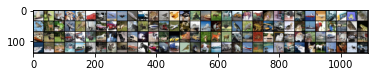

In [4]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


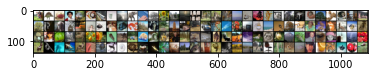

In [5]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /home/marius/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


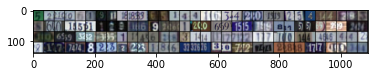

In [6]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR10 on ResNet18 (or load weights)

In [7]:
import torchvision.models as models
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SVHN_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
best_acc = 0  # best test accuracy

In [9]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [10]:
def test(net, epoch, testloader, path, save=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        acc = correct/total
        if acc > best_acc and save: 
            best_acc = acc
            print("saving model at: {}".format(path))
            torch.save(net.state_dict(), path)


        print("test loss: ", test_loss)
        print("current acc: {}; best acc: {}".format(acc, best_acc) )

In [11]:
def train_all():
    SVHN_path = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_s{}.pth'.format(s)
    SVHN_path_best = SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
    lr = 0.1
    epoch = 0
    for e in [10, 10, 5]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(SVHN_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(SVHN_model, epoch, optimizer, SVHN_train_loader, SVHN_path)
            test(SVHN_model, epoch, SVHN_test_loader, SVHN_path_best, save=True)
            epoch += 1
        lr /= 10

In [12]:
#train_all()

In [13]:
##### if you already have a trained model ##############
#SVHN_PATH = 'pretrained_weights/SVHN_resnet18_pretrained.pth'
SVHN_PATH = 'pretrained_weights/SVHN_resnet18_best_s{}.pth'.format(s)
SVHN_model = models.resnet18(pretrained=False, num_classes=10).to(device)
print("loading model from: {}".format(SVHN_PATH))
SVHN_model.load_state_dict(torch.load(SVHN_PATH))#, map_location=torch.device('cpu')))
#test the model
test(SVHN_model, 0, SVHN_test_loader, save=False, path=SVHN_PATH)

loading model from: pretrained_weights/SVHN_resnet18_best_s1.pth
test loss:  1.2069596826622728
current acc: 0.9988859864781807; best acc: 0


In [14]:
targets_CIFAR10 = CIFAR10_testset.targets
targets_CIFAR100 = torch.tensor(CIFAR100_test.targets).clip(0, 9).numpy()
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [15]:
#number of samples to draw from the Gaussian
num_samples = 100

# MAP estimate

In [16]:
SVHN_test_in_MAP = predict_MAP(SVHN_model, SVHN_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_MAP = predict_MAP(SVHN_model, CIFAR100_test_loader, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_MAP = predict_MAP(SVHN_model, CIFAR10_test_loader, device=device).cpu().numpy()

In [17]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_MAP)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_MAP)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_MAP)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.005910237319767475
5.928686141967773
6.07769775390625


In [18]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_MAP))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_MAP))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_MAP))

0.007420878266376118
0.7157020202020201
0.7026162727272728


In [19]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(SVHN_test_in_MAP, targets_SVHN)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(SVHN_test_in_MAP, SVHN_test_out_CIFAR10_MAP, targets_CIFAR10)

In [20]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'SVHN', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')

[In, MAP, SVHN] Accuracy: 0.999; average entropy: 0.017;     MMC: 0.996; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.072; Average entropy: 0.613;    MMC: 0.788; AUROC: 0.961; Prob @ correct: 0.100
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.598;    MMC: 0.793; AUROC: 0.959; Prob @ correct: 0.100


# Diagonal estimate

In [21]:
la_diag = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='diag',
                     prior_precision=1e+1) # 5e-4 # Choose prior precision such that the MMC for inclass is slightly lower than for MAP
la_diag.fit(SVHN_train_loader)

In [22]:
SVHN_test_in_D = predict_samples(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_D = predict_samples(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_D = predict_samples(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.5538545500000005
time:  1.6771893700000007
time:  0.6999351800000042


In [23]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.018192918971180916
4.646116733551025
4.739509582519531


In [24]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_D))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_D))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_D))

0.01655452807112303
0.6150551212121214
0.6000809696969698


In [25]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(SVHN_test_in_D, targets_SVHN)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(SVHN_test_in_D, SVHN_test_out_CIFAR10_D, targets_CIFAR10)

In [26]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'SVHN', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'SVHN', 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D,  'SVHN', 'CIFAR10', 'Diag')

[In, Diag, SVHN] Accuracy: 0.999; average entropy: 0.077;     MMC: 0.984; Prob @ correct: 0.100
[Out-CIFAR100, Diag, SVHN] Accuracy: 0.072; Average entropy: 0.613;    MMC: 0.687; AUROC: 0.957; Prob @ correct: 0.100
[Out-CIFAR10, Diag, SVHN] Accuracy: 0.089; Average entropy: 0.907;    MMC: 0.689; AUROC: 0.959; Prob @ correct: 0.100


# KFAC estimate

In [27]:
la_kron = Laplace(SVHN_model, 'classification', 
                     subset_of_weights='last_layer', 
                     hessian_structure='kron',
                     prior_precision=5e-1) # 5e-4 # Choose prior precision according to weight decay
la_kron.fit(SVHN_train_loader)

/home/marius/anaconda3/lib/python3.9/site-packages/laplace/utils.py:137: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)
  L, W = torch.symeig(M, eigenvectors=True)


In [28]:
SVHN_test_in_K = predict_samples(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_K = predict_samples(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_K = predict_samples(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.293039682
time:  1.9673460089999963
time:  0.9760828089999976


In [29]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_K)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_K)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_K)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.020048754289746284
4.464244365692139
4.56271505355835


In [30]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_K))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_K))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_K))

0.018888566829946666
0.5826889090909092
0.5669742525252526


In [31]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(SVHN_test_in_K, targets_SVHN)
acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100_K, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR100_K, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(SVHN_test_in_K, SVHN_test_out_CIFAR10_K, targets_CIFAR10)

In [32]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'SVHN', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_K, prob_correct_out_CIFAR100_K, ent_out_CIFAR100, MMC_out_CIFAR100_K, auroc_out_CIFAR100_K, 'SVHN', 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K,  'SVHN', 'CIFAR10', 'KFAC')

[In, KFAC, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.983; Prob @ correct: 0.100
[Out-CIFAR100, KFAC, SVHN] Accuracy: 0.072; Average entropy: 0.613;    MMC: 0.655; AUROC: 0.959; Prob @ correct: 0.100
[Out-CIFAR10, KFAC, SVHN] Accuracy: 0.089; Average entropy: 1.001;    MMC: 0.657; AUROC: 0.960; Prob @ correct: 0.100


# Laplace Bridge estimate

In [33]:
SVHN_test_in_LB_D = predict_LB(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_D = predict_LB(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_D = predict_LB(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  3.589077848999999
time:  1.3590799669999996
time:  0.4541690740000064


In [34]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_LB_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_LB_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_LB_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.007380282040685415
4.725522041320801
4.770489692687988


In [35]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_LB_D))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_LB_D))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_LB_D))

0.008365186126787237
0.6674126161616161
0.6592007523799243


In [36]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LB_D, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR100_LB_D, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LB_D, SVHN_test_out_CIFAR10_LB_D, targets_CIFAR10)

In [37]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB,  'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB,  'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.026;     MMC: 0.995; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.072; Average entropy: 0.839;    MMC: 0.739; AUROC: 0.962; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.803;    MMC: 0.749; AUROC: 0.960; Prob @ correct: 0.100


# LB diag norm

In [38]:
SVHN_test_in_LB_Dn = predict_LB_norm(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_Dn = predict_LB_norm(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_Dn = predict_LB_norm(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.072671159999999
time:  2.3288039489999974
time:  0.6605785250000054


In [39]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_LB_Dn)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_LB_Dn)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_LB_Dn)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.01422918401658535
4.458553791046143
4.349743843078613


In [40]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_LB_Dn))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_LB_Dn))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_LB_Dn))

0.012095102065523089
0.6785721010101011
0.6617892626262627


In [41]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(SVHN_test_in_LB_Dn, targets_SVHN)
acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB = get_out_dist_values(SVHN_test_in_LB_Dn, SVHN_test_out_CIFAR100_LB_Dn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(SVHN_test_in_LB_Dn, SVHN_test_out_CIFAR10_LB_Dn, targets_CIFAR10)

In [42]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB, prob_correct_out_CIFAR100_LB, ent_out_CIFAR100_LB, MMC_out_CIFAR100_LB, auroc_out_CIFAR100_LB,  'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB,  'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.988; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.072; Average entropy: 0.822;    MMC: 0.750; AUROC: 0.944; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.818;    MMC: 0.751; AUROC: 0.947; Prob @ correct: 0.100


# Laplace Bridge KFAC

In [43]:
SVHN_test_in_LB_KFAC = predict_LB(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFAC = predict_LB(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFAC = predict_LB(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  6.183415423000007
time:  2.306226734000006
time:  0.7325703850000025


In [44]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_LB_KFAC)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_LB_KFAC)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_LB_KFAC)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.008150339126586914
4.664709568023682
4.662527561187744


In [45]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_LB_KFAC))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_LB_KFAC))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_LB_KFAC))

0.008975817641690417
0.6592949191919193
0.6505005858585858


In [46]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFAC, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR100_LB_KFAC, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFAC, SVHN_test_out_CIFAR10_LB_KFAC, targets_CIFAR10)

In [47]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.029;     MMC: 0.994; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.070; Average entropy: 0.872;    MMC: 0.730; AUROC: 0.962; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.089; Average entropy: 0.835;    MMC: 0.740; AUROC: 0.959; Prob @ correct: 0.100


# LB KFAC norm

In [48]:
SVHN_test_in_LB_KFACn = predict_LB_norm(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_LB_KFACn = predict_LB_norm(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_LB_KFACn = predict_LB_norm(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  6.8179554689999975
time:  2.638589561999993
time:  0.9604569000000112


In [49]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_LB_KFACn)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_LB_KFACn)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_LB_KFACn)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.018901605159044266
4.127094268798828
3.938950777053833


In [50]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_LB_KFACn))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_LB_KFACn))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_LB_KFACn))

0.017087341609084077
0.5749210202020203
0.5559448888888889


In [51]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(SVHN_test_in_LB_KFACn, targets_SVHN)
acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR100_LB_KFACn, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(SVHN_test_in_LB_KFACn, SVHN_test_out_CIFAR10_LB_KFACn, targets_CIFAR10)

In [52]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'SVHN', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR100_LB_KFAC, prob_correct_out_CIFAR100_LB_KFAC, ent_out_CIFAR100_LB_KFAC, MMC_out_CIFAR100_LB_KFAC, auroc_out_CIFAR100_LB_KFAC, 'SVHN', 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'SVHN', 'CIFAR10', 'Laplace Bridge')

[In, Laplace Bridge, SVHN] Accuracy: 0.999; average entropy: 0.068;     MMC: 0.985; Prob @ correct: 0.100
[Out-CIFAR100, Laplace Bridge, SVHN] Accuracy: 0.069; Average entropy: 1.150;    MMC: 0.644; AUROC: 0.953; Prob @ correct: 0.100
[Out-CIFAR10, Laplace Bridge, SVHN] Accuracy: 0.090; Average entropy: 1.146;    MMC: 0.646; AUROC: 0.955; Prob @ correct: 0.100


# Compare to probit approximation (extended MacKay)

In [53]:
SVHN_test_in_PROBIT_D = predict_probit(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_PROBIT_D = predict_probit(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_PROBIT_D = predict_probit(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  5.555627483999999
time:  2.071178101000001
time:  0.48841114600000424


In [54]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_PROBIT_D)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_PROBIT_D)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_PROBIT_D)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.015613588504493237
4.464162349700928
4.496768474578857


In [55]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_PROBIT_D))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_PROBIT_D))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_PROBIT_D))

0.013731526233446945
0.6374565656565657
0.6228902929292929


In [56]:
acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT = get_in_dist_values(SVHN_test_in_PROBIT_D, targets_SVHN)
acc_out_CIFAR100_PROBIT, prob_correct_out_CIFAR100_PROBIT, ent_out_CIFAR100_PROBIT, MMC_out_CIFAR100_PROBIT, auroc_out_CIFAR100_PROBIT = get_out_dist_values(SVHN_test_in_PROBIT_D, SVHN_test_out_CIFAR100_PROBIT_D, targets_CIFAR100)
acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT = get_out_dist_values(SVHN_test_in_PROBIT_D, SVHN_test_out_CIFAR10_PROBIT_D, targets_CIFAR10)

In [57]:
print_in_dist_values(acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT, 'SVHN', 'PROBIT')
print_out_dist_values(acc_out_CIFAR100_PROBIT, prob_correct_out_CIFAR100_PROBIT, ent_out_CIFAR100_PROBIT, MMC_out_CIFAR100_PROBIT, auroc_out_CIFAR100_PROBIT, 'CIFAR100', 'PROBIT')
print_out_dist_values(acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT, 'CIFAR10', 'PROBIT')

[In, PROBIT, SVHN] Accuracy: 0.999; average entropy: 0.074;     MMC: 0.987; Prob @ correct: 0.100
[Out-PROBIT, KFAC, CIFAR100] Accuracy: 0.072; Average entropy: 0.890;    MMC: 0.710; AUROC: 0.960; Prob @ correct: 0.100
[Out-PROBIT, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 0.880;    MMC: 0.712; AUROC: 0.962; Prob @ correct: 0.100


### PROBIT KFAC

In [58]:
SVHN_test_in_PROBIT_K = predict_probit(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_PROBIT_K = predict_probit(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_PROBIT_K = predict_probit(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

time:  4.133159148000004
time:  1.588213764999992
time:  0.7386514949999992


In [59]:
# compute average log-likelihood for Diag
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_in_PROBIT_K)).log_prob(torch.tensor(targets_SVHN)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR100_PROBIT_K)).log_prob(torch.tensor(targets_CIFAR100)).mean().item())
print(-torch.distributions.Categorical(torch.tensor(SVHN_test_out_CIFAR10_PROBIT_K)).log_prob(torch.tensor(targets_CIFAR10)).mean().item())

0.10542333871126175
3.2627480030059814
3.2611489295959473


In [60]:
#compute the Expected confidence estimate
print(scoring.expected_calibration_error(targets_SVHN, SVHN_test_in_PROBIT_K))
print(scoring.expected_calibration_error(targets_CIFAR100, SVHN_test_out_CIFAR100_PROBIT_K))
print(scoring.expected_calibration_error(targets_CIFAR10, SVHN_test_out_CIFAR10_PROBIT_K))

0.09443428600696573
0.46595622222222227
0.4484872222222223


In [61]:
acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT = get_in_dist_values(SVHN_test_in_PROBIT_K, targets_SVHN)
acc_out_CIFAR100_PROBIT, prob_correct_out_CIFAR100_PROBIT, ent_out_CIFAR100_PROBIT, MMC_out_CIFAR100_PROBIT, auroc_out_CIFAR100_PROBIT = get_out_dist_values(SVHN_test_in_PROBIT_K, SVHN_test_out_CIFAR100_PROBIT_K, targets_CIFAR100)
acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT = get_out_dist_values(SVHN_test_in_PROBIT_K, SVHN_test_out_CIFAR10_PROBIT_K, targets_CIFAR10)

In [62]:
print_in_dist_values(acc_in_PROBIT, prob_correct_in_PROBIT, ent_in_PROBIT, MMC_in_PROBIT, 'SVHN', 'PROBIT')
print_out_dist_values(acc_out_CIFAR100_PROBIT, prob_correct_out_CIFAR100_PROBIT, ent_out_CIFAR100_PROBIT, MMC_out_CIFAR100_PROBIT, auroc_out_CIFAR100_PROBIT, 'CIFAR100', 'PROBIT')
print_out_dist_values(acc_out_CIFAR10_PROBIT, prob_correct_out_CIFAR10_PROBIT, ent_out_CIFAR10_PROBIT, MMC_out_CIFAR10_PROBIT, auroc_out_CIFAR10_PROBIT, 'CIFAR10', 'PROBIT')

[In, PROBIT, SVHN] Accuracy: 0.999; average entropy: 0.475;     MMC: 0.905; Prob @ correct: 0.100
[Out-PROBIT, KFAC, CIFAR100] Accuracy: 0.071; Average entropy: 1.451;    MMC: 0.537; AUROC: 0.956; Prob @ correct: 0.100
[Out-PROBIT, KFAC, CIFAR10] Accuracy: 0.089; Average entropy: 1.448;    MMC: 0.538; AUROC: 0.959; Prob @ correct: 0.100


In [63]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Compare to Second-order Delta Posterior Predictive

In [ ]:
SVHN_test_in_SODPP_D = predict_second_order_dpp(la_diag, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_D = predict_second_order_dpp(la_diag, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_D = predict_second_order_dpp(la_diag, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

In [ ]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_D, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR100_SODPP_D, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_D, SVHN_test_out_CIFAR10_SODPP_D, targets_CIFAR10)

In [ ]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')

### SODPP KFAC

In [ ]:
SVHN_test_in_SODPP_K = predict_second_order_dpp(la_kron, SVHN_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR100_SODPP_K = predict_second_order_dpp(la_kron, CIFAR100_test_loader, timing=True, device=device).cpu().numpy()
SVHN_test_out_CIFAR10_SODPP_K = predict_second_order_dpp(la_kron, CIFAR10_test_loader, timing=True, device=device).cpu().numpy()

In [ ]:
acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP = get_in_dist_values(SVHN_test_in_SODPP_K, targets_SVHN)
acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR100_SODPP_K, targets_CIFAR100)
acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_SODPP = get_out_dist_values(SVHN_test_in_SODPP_K, SVHN_test_out_CIFAR10_SODPP_K, targets_CIFAR10)

In [ ]:
print_in_dist_values(acc_in_SODPP, prob_correct_in_SODPP, ent_in_SODPP, MMC_in_SODPP, 'SVHN', 'SODPP')
print_out_dist_values(acc_out_CIFAR100_SODPP, prob_correct_out_CIFAR100_SODPP, ent_out_CIFAR100_SODPP, MMC_out_CIFAR100_SODPP, auroc_out_CIFAR100_EMK, 'CIFAR100', 'SODPP')
print_out_dist_values(acc_out_CIFAR10_SODPP, prob_correct_out_CIFAR10_SODPP, ent_out_CIFAR10_SODPP, MMC_out_CIFAR10_SODPP, auroc_out_CIFAR10_EMK, 'CIFAR10', 'SODPP')